# Task 2

### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

El objetivo de esta parte es implementar el pipeline de alineación sin depender de cajas negras. Por ello considere que no deben de usar cv2.findHonography o cv2.RANSAC. Además para este laboratorio necesitara crear su propio dataset, por ello tome 3 fotografías propias de una escena planar (i.e. una pancarta en una pared, un cuadro, o una fachada de edificio lejana) con ángulos y perspectivas drásticamente diferentes.


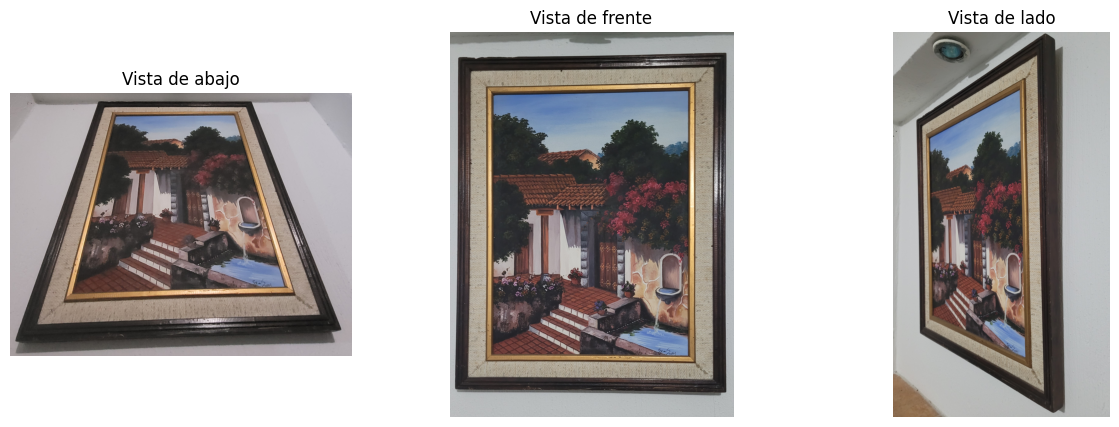

In [24]:
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img1 = mpimg.imread('imgs/abajo.jpg')
img2 = mpimg.imread('imgs/frente.jpg')
img3 = mpimg.imread('imgs/lado.jpg')
# por algun motivo la imagegn 3 sale horizontalmente, entonces le di vuelta jej
img3 = np.rot90(img3, k=-1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

axes[0].imshow(img1)
axes[0].set_title('Vista de abajo')
axes[0].axis('off')  

axes[1].imshow(img2)
axes[1].set_title('Vista de frente')
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title('Vista de lado')
axes[2].axis('off')

# plt.tight_layout()  # Ajustar espaciado
plt.show()

# 1. Detección y Macheo
* a. Utilice SIFT u ORB (permitido usar OpenCV aquí) para detectar puntos de interés y descriptores.
* b. Realice un emparejamiento de fuerza bruta (Brute-Force Matcher).
* c. Requisito: Visualice los matches antes de filtrar. Debe verse una cantidad considerable de ruido/errores

## Parte a

In [25]:
# parte a


# Rutas de tus archivos (según tu estructura de carpetas)
PATH_REF = 'imgs/frente.jpg'   # La imagen que es la meta
PATH_OBJ = 'imgs/abajo.jpg'     # La imagen que queremos enderezar

print(f"Referencia: {PATH_REF}\n Objetivo:   {PATH_OBJ}")

# 
img_ref_bgr = cv2.imread(PATH_REF)
img_obj_bgr = cv2.imread(PATH_OBJ)

# Validación simple
if img_ref_bgr is None or img_obj_bgr is None:
    raise ValueError("No se encontro la img")

img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)
img_obj_rgb = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2RGB)

img_ref_gray = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2GRAY)
img_obj_gray = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()

# los keypoints y descriptores
kp_ref, des_ref = sift.detectAndCompute(img_ref_gray, None)
kp_obj, des_obj = sift.detectAndCompute(img_obj_gray, None)

print(f"Keypoints en Referencia: {len(kp_ref)}")
print(f"Keypoints en Objetivo:   {len(kp_obj)}")



Referencia: imgs/frente.jpg
 Objetivo:   imgs/abajo.jpg
Keypoints en Referencia: 28311
Keypoints en Objetivo:   10239


## Parte b

In [26]:
# Usamos Fuerza Bruta con distancia Euclidiana, el k=2 igual que en el lab pasado significa
# los 2 mejores matches
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_crudos = matcher.knnMatch(des_ref, des_obj, k=2)

print(f"Matches Totales: {len(matches_crudos)}")

Matches Totales: 28311


## Parte c

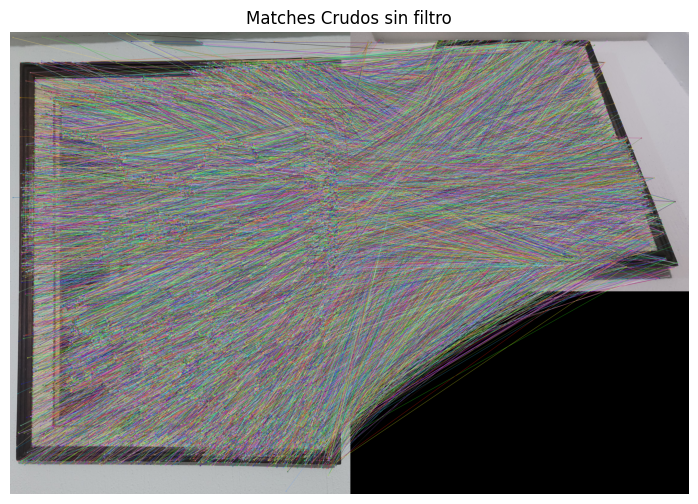

In [27]:
matches_sin_filtro = [m for m, n in matches_crudos]

# Flags=0 dibuja todo. Flags=2 no dibuja puntos huerfanos.
img_ruido = cv2.drawMatches(
    img_ref_rgb, kp_ref, 
    img_obj_rgb, kp_obj, 
    matches_sin_filtro, # Pasamos la muestra ruidosa
    None, 
    flags=2
)

plt.figure(figsize=(15, 6))
plt.title("Matches Crudos sin filtro")
plt.imshow(img_ruido)
plt.axis('off')
plt.show()

Matches Totales: 28311
Matches Buenos: 1102


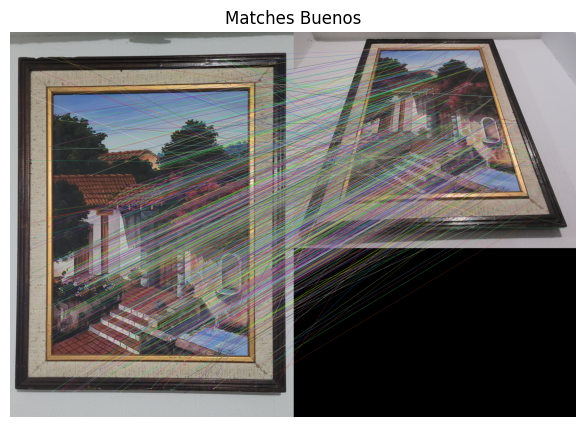

In [28]:
# esto es algo extra que quisimos poner para verificar el match con filtro como el lab pasado

ratio = 0.75
matches_buenos = []

for m, n in matches_crudos:
    if m.distance < ratio * n.distance:
        matches_buenos.append(m)

print(f"Matches Totales: {len(matches_crudos)}")
print(f"Matches Buenos: {len(matches_buenos)}")

# visualizacion de los matches
img_matches = cv2.drawMatches(img_ref_rgb, kp_ref, img_obj_rgb, kp_obj, matches_buenos, None, flags=2)
plt.figure(figsize=(15, 5))
plt.title("Matches Buenos")
plt.imshow(img_matches)
plt.axis('off')
plt.show()


# 2